# **Solving the Advection-Diffusion Equation Using PI-KAN & NeuroMANCER**

# **Motivation:**
## The advection-diffusion equation is a key model for simulating the transport and dispersion of emissions in sustainable energy systems. In this scenario, we consider a steady-state case with a continuous emission source in a room. By using the PI-KAN framework, we can predict the spatial distribution of these emissions and visualize how they spread within the confined space. However, in more complex situations, obtaining an exact solution is either computationally expensive or infeasible. To address this challenge, we turn to the NeuroMANCER library, which leverages differential programming to efficiently approximate the solution, offering a practical alternative to traditional methods.

****************************************

# Install necessary packages for the project

In [1]:
!pip install neuromancer
!pip install pyDOE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.9/174.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=b215c15cb931c9ed0ed18b1ac5e74c65402bb1836744497db895701d6c2ac92d
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


# Importing necessary libraries

In [1]:
# torch and numpy imports
import torch
import torch.nn as nn
import numpy as np

# plotting imports
import matplotlib.pyplot as plt

# filter some user warnings from torch broadcast
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)
#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: cuda


# **Advection-diffusion equation:**
$$u \frac{\partial \phi}{\partial x} + v \frac{\partial \phi}{\partial y} = \Gamma^{\phi}\left( \frac{\partial^2 \phi}{ \partial x^2} + \frac{\partial^2 \phi}{ \partial y^2}\right) + s$$

# **Assumed solution:**
$$\phi(x,y) = \left(x + \frac{e^{
            \left(\frac{x u}{\Gamma^{\phi}}\right)} - 1}{1 - e^{
            \left(\frac{u}{\Gamma^{\phi}}\right)}}\right) \times \left(y + \frac{e^{
            \left(\frac{y v}{\Gamma^{\phi}}\right)} - 1}{1 - e^{
            \left(\frac{v}{\Gamma^{\phi}}\right)}}\right)$$

# Assuming this solution we calculated the source term, s, analytically in the advection-diffusion equation.

In [3]:
# Assumed exact solution for the steady-state advection-diffusion equation
def f_real(u,v,Gamma_phi,x,y):
  """
  This function will calculate the true solution of the advection-diffusion equation
  u: Advection coefficient along x-direction
  v: Advection coefficient along y-direction
  Gamma_phi: Diffusion coefficient
  x: x-coordinate
  y: y-coordinate
  """

  term_x = (x + (((torch.exp(u*x/Gamma_phi) - 1))/(1-(torch.exp(u/Gamma_phi)))))
  term_y = (y + (((torch.exp(v*y/Gamma_phi) - 1))/(1-(torch.exp(v/Gamma_phi)))))
  Element_cen_phi_Actual = term_x*term_y
  return Element_cen_phi_Actual

# define range of the space variables:
x_min=0
x_max=1
y_min=0
y_max=1

# define number of spatial points
total_points_x=500
total_points_y=500

# generate samples of x, y
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
y=torch.linspace(y_min,y_max,total_points_y).view(-1,1)

# Create the mesh of x, y
X,Y=torch.meshgrid(x.squeeze(1),y.squeeze(1), indexing='ij')

# Evaluate exact solution sol(x,y) on the mesh
u = torch.tensor(5)
v = torch.tensor(5)
Gamma_phi = torch.tensor(1)
sol_real=f_real(u,v,Gamma_phi,X,Y)

# data shapes
print(x.shape, y.shape)
print(X.shape, Y.shape, sol_real.shape)

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([500, 500]) torch.Size([500, 500]) torch.Size([500, 500])


In [4]:
# min and max values of the PDE solution
solmin = sol_real.min()
solmax = sol_real.max()
print(solmin, solmax)

tensor(0.) tensor(0.2338)


# Plot the exact solution

In [5]:
def plot3D(X, Y, sol):

    #     2D
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    cm = ax1.contourf(X.numpy(), Y.numpy(), sol.numpy(), 20,cmap="viridis")
    # Add a colorbar to a plot
    fig.colorbar(cm, ax=ax1)
    ax1.set_title(r'$\phi(x,y)$')
    ax1.set_xlabel('y')
    ax1.set_ylabel('x')
    ax1.set_aspect('equal')

    #     3D
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X.numpy(), Y.numpy(), sol.numpy(),cmap="viridis")
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel(r'$\phi(x,y)$')
    fig.tight_layout()

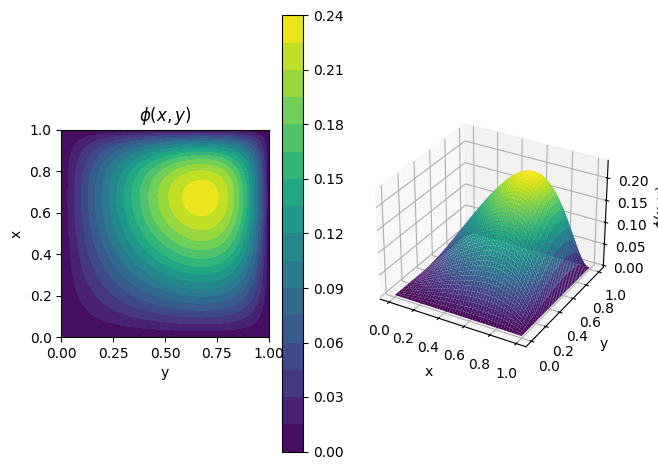

In [6]:
plot3D(X,Y,sol_real)

In [7]:
# Transform the mesh into a 2-column vector
X_test= X.transpose(1,0).flatten()[:,None].float() # the input dataset of x
Y_test= Y.transpose(1,0).flatten()[:,None].float() # the input dataset of y
sol_test= sol_real.transpose(1,0).flatten()[:,None].float() # the real solution over (x,y)
print(X_test.shape,Y_test.shape,sol_test.shape)

torch.Size([250000, 1]) torch.Size([250000, 1]) torch.Size([250000, 1])


# Setting the Boundary Conditions (BC)

In [8]:
#   Left Edge
left_X = X[:, [0]]
left_Y = Y[:, [0]]
left_sol = f_real(u,v,Gamma_phi,left_X,left_Y)
print(left_X.shape, left_Y.shape, left_sol.shape)

#   Right Edge
right_X = X[:, [-1]]
right_Y = Y[:, [-1]]
right_sol = f_real(u,v,Gamma_phi,right_X,right_Y)
print(right_X.shape, right_Y.shape, right_sol.shape)

#   Bottom Edge
bottom_X = X[[0], :].T
bottom_Y = Y[[0], :].T
bottom_sol = f_real(u,v,Gamma_phi,bottom_X,bottom_Y)
print(bottom_X.shape, bottom_Y.shape, bottom_sol.shape)

#   Top Edge
top_X = X[[-1], :].T
top_Y = Y[[-1], :].T
top_sol = f_real(u,v,Gamma_phi,top_X,top_Y)
print(top_X.shape, top_Y.shape, top_sol.shape)

torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([500, 1])


# **Note:** Since this is an elliptic partial differential equation (PDE) in a steady-state scenario, the initial conditions do not influence the steady-state solution. In steady-state problems, the system has reached an equilibrium where the time derivative is zero, meaning the solution depends only on the boundary conditions and not on the initial state. Therefore, initial conditions are not considered in this case.

In [9]:
# Get all the boundary condition data
X_train = torch.vstack([left_X, right_X, bottom_X, top_X])
Y_train = torch.vstack([left_Y, right_Y, bottom_Y, top_Y])
sol_train = torch.vstack([left_sol, right_sol, bottom_sol, top_sol])
print(X_train.shape, Y_train.shape, sol_train.shape)

# Choose (Nu) Number of training points for boundary conditions
Nu = 200

# Randomly sample Nu points of our available boundary condition data:
idx = np.sort(np.random.choice(X_train.shape[0], Nu, replace=False))
X_train_Nu = X_train[idx, :].float()  # Training Points  of x at BC
Y_train_Nu = Y_train[idx, :].float()  # Training Points  of y at BC
sol_train_Nu = sol_train[idx, :].float()  # Training Points  of solution at BC
print(X_train_Nu.shape, Y_train_Nu.shape, sol_train_Nu.shape)

torch.Size([2000, 1]) torch.Size([2000, 1]) torch.Size([2000, 1])
torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 1])


# Samples of Collocation Points (CP)

In [10]:
# x Domain bounds
x_lb = X_test[0]  # first value
x_ub = X_test[-1]  # last value
print(x_lb, x_ub)

# y Domain bounds
y_lb = Y_test[0]  # first value
y_ub = Y_test[-1]  # last value
print(y_lb, y_ub)

#  Choose (Nf) Collocation Points to Evaluate the PDE on
Nf = 3000  # Nf: Number of collocation points (Evaluate PDE)

# generate collocation points (CP)
X_train_CP = torch.FloatTensor(Nf, 1).uniform_(float(x_lb), float(x_ub))
Y_train_CP = torch.FloatTensor(Nf, 1).uniform_(float(y_lb), float(y_ub))
print(X_train_CP.shape, Y_train_CP.shape)

# add BC to the collocation points
X_train_Nf = torch.vstack((X_train_CP, X_train_Nu)).float()  # Collocation Points of x (CP)
Y_train_Nf = torch.vstack((Y_train_CP, Y_train_Nu)).float()  # Collocation Points of y (CP)
print(X_train_Nf.shape, Y_train_Nf.shape)

tensor([0.]) tensor([1.])
tensor([0.]) tensor([1.])
torch.Size([3000, 1]) torch.Size([3000, 1])
torch.Size([3200, 1]) torch.Size([3200, 1])


# Plotting the collocation points

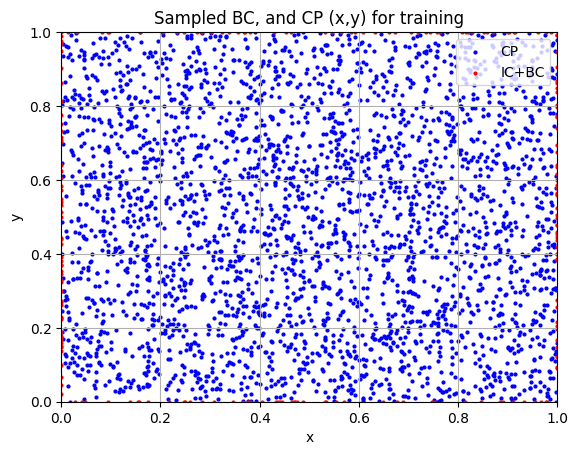

In [11]:
# visualize collocation points for 2D input space (x, y)
plt.figure()
plt.scatter(X_train_CP.detach().numpy(), Y_train_CP.detach().numpy(),
            s=4., c='blue', marker='o', label='CP')
plt.scatter(X_train_Nu.detach().numpy(), Y_train_Nu.detach().numpy(),
            s=4., c='red', marker='o', label='IC+BC')
plt.title('Sampled BC, and CP (x,y) for training')
plt.xlim(x_lb, x_ub)
plt.ylim(y_lb, y_ub)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.show()
plt.show(block=True)

# Create NeuroMANCER datasets

In [12]:
from neuromancer.dataset import DictDataset

# turn on gradients for PINN
X_train_Nf.requires_grad=True
Y_train_Nf.requires_grad=True

# Training dataset
train_data = DictDataset({'x': X_train_Nf, 'y':Y_train_Nf}, name='train')
# test dataset
test_data = DictDataset({'x': X_test, 'y':Y_test, 'sol_test':sol_test}, name='test')

# torch dataloaders
batch_size = X_train_Nf.shape[0]  # full batch training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         collate_fn=test_data.collate_fn,
                                         shuffle=False)

# Defining the machine learning model

In [13]:
from neuromancer.modules import blocks
from neuromancer.system import Node

# KAN to solve the PDE problem bounded in the PDE domain
net = blocks.KANBlock(insize=2, outsize=1, num_layers=5, hidden_size=32)

# symbolic wrapper of the neural net
pde_net = Node(net, ['x', 'y'], ['sol_hat'], name='net')

In [14]:
print("symbolic inputs  of the pde_net:", pde_net.input_keys)
print("symbolic outputs of the pde_net:", pde_net.output_keys)

symbolic inputs  of the pde_net: ['x', 'y']
symbolic outputs of the pde_net: ['sol_hat']


In [15]:
# evaluate forward pass on the train data
net_out = pde_net(train_data.datadict)
net_out['sol_hat'].shape

torch.Size([3200, 1])

In [16]:
from neuromancer.constraint import variable

# symbolic Neuromancer variables
sol_hat = variable('sol_hat')  # PDE solution generated as the output of a neural net (pde_net)
y = variable('y')
x = variable('x')

In [17]:
# get the symbolic derivatives
beta = 1
dsol_dx = sol_hat.grad(x)
dsol_dy = sol_hat.grad(y)
dsol2_dx2 = dsol_dx.grad(x)
dsol2_dy2 = dsol_dy.grad(y)

# Source term because of the diffusion term
d_term_x = (x + (((torch.exp(u*x/Gamma_phi) - 1))/(1-(torch.exp(u/Gamma_phi)))))
d_term_y = (y + (((torch.exp(v*y/Gamma_phi) - 1))/(1-(torch.exp(v/Gamma_phi)))))
d_term_x_derivative = (1 + (((u/Gamma_phi)*(torch.exp(u*x/Gamma_phi)))/(1-(torch.exp(u/Gamma_phi)))))
d_term_x_d_derivative = (((((u/Gamma_phi)**2)*(torch.exp(u*x/Gamma_phi)))/(1-(torch.exp(u/Gamma_phi)))))
d_term_y_derivative = (1 + (((v/Gamma_phi)*(torch.exp(v*y/Gamma_phi)))/(1-(torch.exp(v/Gamma_phi)))))
d_term_y_d_derivative = (((((v/Gamma_phi)**2)*(torch.exp(v*y/Gamma_phi)))/(1-(torch.exp(v/Gamma_phi)))))
source_diff = Gamma_phi*((d_term_x_d_derivative*d_term_y) + (d_term_x*d_term_y_d_derivative))

# Source term because of the advection term
a_term_x = (x + (((torch.exp(u*x/Gamma_phi) - 1))/(1-(torch.exp(u/Gamma_phi)))))
a_term_y = (y + (((torch.exp(v*y/Gamma_phi) - 1))/(1-(torch.exp(v/Gamma_phi)))))
a_term_x_derivative = (1 + (((u/Gamma_phi)*(torch.exp(u*x/Gamma_phi)))/(1-(torch.exp(u/Gamma_phi)))))
a_term_x_d_derivative = (((((u/Gamma_phi)**2)*(torch.exp(u*x/Gamma_phi)))/(1-(torch.exp(u/Gamma_phi)))))
a_term_y_derivative = (1 + (((v/Gamma_phi)*(torch.exp(v*y/Gamma_phi)))/(1-(torch.exp(v/Gamma_phi)))))
a_term_y_d_derivative = (((((v/Gamma_phi)**2)*(torch.exp(v*y/Gamma_phi)))/(1-(torch.exp(v/Gamma_phi)))))
source_advec = (u*a_term_x_derivative*a_term_y) + (v*a_term_x*a_term_y_derivative)

# get the PINN form
f_pinn = (u*dsol_dx) + (v*dsol_dy) - (Gamma_phi*(dsol2_dx2 + dsol2_dy2)) - source_advec + source_diff

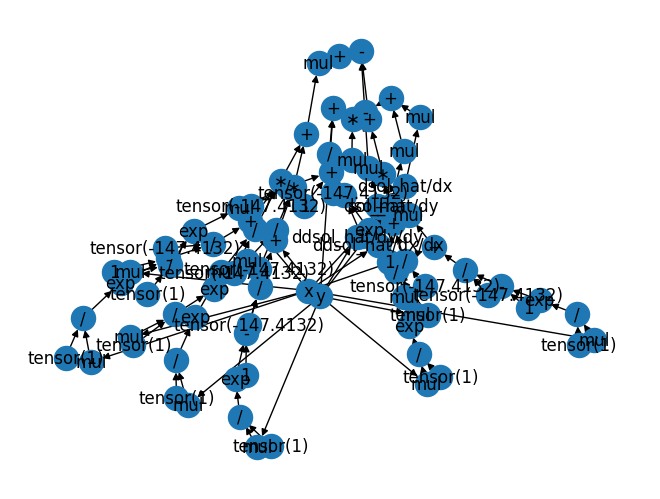

In [18]:
# computational graph of the PINN neural network
f_pinn.show()

In [19]:
# scaling factor for better convergence
scaling = 100.
scaling_bc = 1000.

# PDE CP loss
ell_f = scaling*(f_pinn == 0.)^2

# PDE BC loss (10 times that of the other component of the loss)
ell_u = scaling_bc*(sol_hat[-Nu:] == sol_train_Nu)^2  # remember we stacked CP with BC

# output constraints to bound the PINN solution in the PDE output domain
con_1 = scaling*(sol_hat <= solmax)^2
con_2 = scaling*(sol_hat >= solmin)^2

In [20]:
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem

# create Neuromancer optimization loss
pinn_loss = PenaltyLoss(objectives=[ell_f, ell_u], constraints=[con_1, con_2])

# construct the PINN optimization problem
problem = Problem(nodes=[pde_net],      # list of nodes (neural nets) to be optimized
                  loss=pinn_loss,       # physics-informed loss function
                  grad_inference=True   # argument for allowing computation of gradients at the inference time)
                 )

# Visualize the problem graph. Note: must have graphviz installed in the system
# problem.show()

# Construct Trainer and solve the problem  

In [21]:
from neuromancer.trainer import Trainer

optimizer = torch.optim.AdamW(problem.parameters(), lr=0.001)
epochs = 1000

#  Neuromancer trainer
trainer = Trainer(
    problem.to(device),
    train_loader,
    optimizer=optimizer,
    epochs=epochs,
    epoch_verbose=200,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs,
    device=device
)

In [22]:
# Train PINN
best_model = trainer.train()

# load best trained model
problem.load_state_dict(best_model)

epoch: 0  train_loss: 1016.4752807617188
epoch: 200  train_loss: 6.652040481567383
epoch: 400  train_loss: 1.4210165739059448
epoch: 600  train_loss: 0.7093360424041748
epoch: 800  train_loss: 0.29353392124176025


<All keys matched successfully>

In [23]:
# Evaluate trained PINN on test data
PINN = problem.nodes[0].cpu()
sol1= PINN(test_data.datadict)['sol_hat']

In [24]:
# Arrange data for plotting
sol_pinn = sol1.reshape(shape=[500,500]).transpose(1,0).detach().cpu()

****************************************************

# PI-KAN Solution

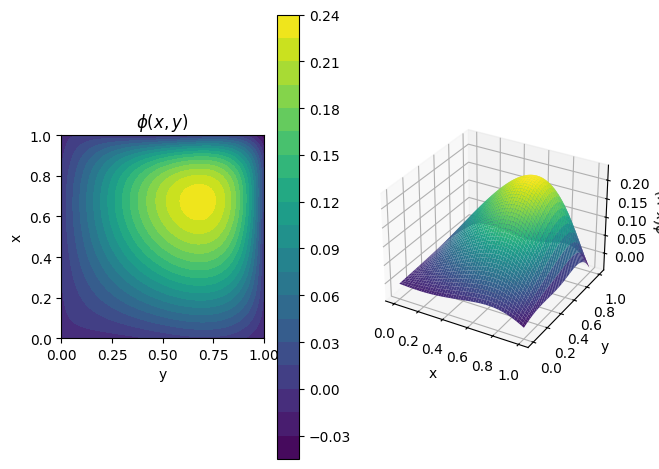

In [25]:
# Plot PINN solution
plot3D(X, Y, sol_pinn)

**************************************

# Actual Solution

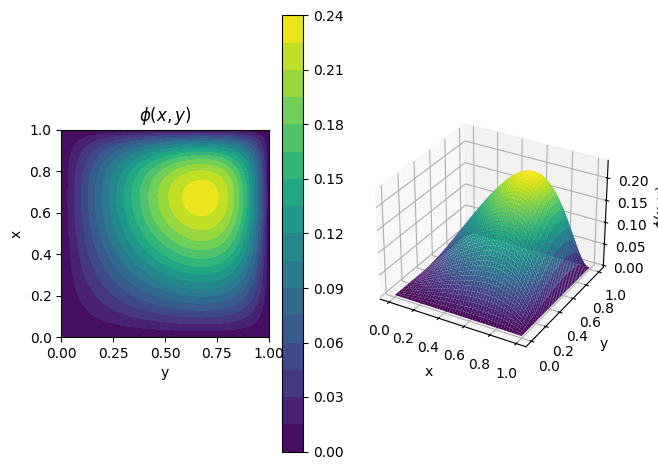

In [26]:
# plot exact PDE solution
plot3D(X, Y, sol_real)

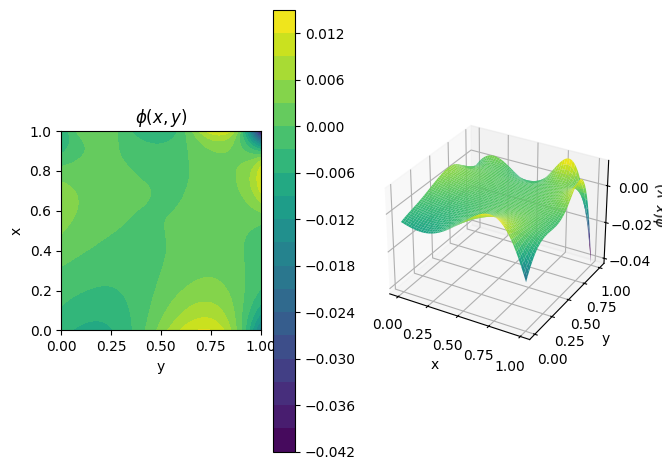

In [27]:
# plot residuals PINN - exact PDE
plot3D(X, Y, sol_pinn-sol_real)

***************************************************

# **CITATIONS**

[1]. [NeuroMANCER: Neural Modules with Adaptive Nonlinear Constraints and Efficient Regularizations](https://github.com/pnnl/neuromancer)

[2] [Liu, Ziming, et al. (2024). KAN: Kolmogorov-Arnold Networks.](https://arxiv.org/abs/2404.19756)

[3] https://github.com/Blealtan/efficient-kan

[4] [Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations.](https://www.sciencedirect.com/science/article/abs/pii/S0021999118307125)

[5] https://github.com/jdtoscano94/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets/tree/main

[6] https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main

[7] [NeuroMANCER Example: Burgers' Equation](https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/PDEs/Part_2_PINN_BurgersEquation.ipynb)

[8] [NeuroMANCER Example: Navier-Stokes equation (lid-driven cavity flow, steady-state, KAN)](https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/PDEs/Part_6_PINN_NavierStokesCavitySteady_KAN.ipynb#scrollTo=Y61YA90-WIZ1)